In [31]:
import matplotlib.pyplot as plt
import os
import ternary
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
import multiprocessing
import enchant

In [32]:
def psipredfile(file):
    
    with open(file, "r") as file:
        lines = file.readlines()

    residue_position = []
    amino_acids = []
    secondary_structure  = []   
    C_predict = []
    H_predict = []
    E_predict = []

    for line in lines:
        line = line.strip()
        if not line or line.startswith("#"):
            continue

        fields = line.split()

        if len(fields) >= 4:
            residue_position.append(fields[0])
            amino_acids.append(fields[1])
            secondary_structure.append(fields[2])  # Predicted secondary structure information

            C_predict.append(fields[3])
            H_predict.append(fields[4])
            E_predict.append(fields[5])

    return residue_position,amino_acids,secondary_structure,C_predict,H_predict,E_predict


In [33]:
def percentage_structure(file, barplot=True):
    
    residue_position,amino_acids,secondary_structure,C_predict,H_predict,E_predict = psipredfile(file)
    
    total_count = len(secondary_structure)
    c_count = secondary_structure.count('C')
    h_count = secondary_structure.count('H')
    e_count = secondary_structure.count('E')

    c_percentage = (c_count / total_count) * 100
    h_percentage = (h_count / total_count) * 100
    e_percentage = (e_count / total_count) * 100
    
    if barplot == True:
        
        labels = ['C', 'H', 'E']
        percentages = [c_percentage, h_percentage, e_percentage]

        plt.bar(labels, percentages)
        plt.xlabel('Secondary Structure')
        plt.ylabel('Percentage')
        plt.title('Secondary Structure Prediction')
        plt.show()

    return c_percentage,h_percentage,e_percentage


In [34]:
def count_consecutive_lengths(file):
    
    residue_position,amino_acids,secondary_structure,C_predict,H_predict,E_predict = psipredfile(file)
    
    counts = {"C": [], "H": [], "E": []}
    current_structure = secondary_structure[0]
    current_count = 1

    for structure in secondary_structure[1:]:
        if structure == current_structure:
            current_count += 1
        else:
            counts[current_structure].append(current_count)
            current_structure = structure
            current_count = 1

    counts[current_structure].append(current_count)

    return counts
    
def plot_consecutive_lengths_box(file, lengthsplot = True):
    consecutive_counts = count_consecutive_lengths(file)
    
    data = [lengths for lengths in consecutive_counts.values()]
    labels = list(consecutive_counts.keys())

    plt.boxplot(data, labels=labels)
    plt.xlabel('Secondary Structures')
    plt.ylabel('Consecutive Length')
    plt.title('Box Plot of Consecutive Lengths for Secondary Structures')
    plt.show()


In [35]:
def shannon_entropy(secondary_structure):
    unique_chars, char_counts = np.unique(list(secondary_structure), return_counts=True)
    probabilities = char_counts / len(secondary_structure)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def calculate_entropy_matrix(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".ss2")]
    num_files = len(files)

    entropy_matrix = np.zeros((num_files, num_files))
    secondary_structure_data = {}  # Dictionary to store secondary structure data
    
    count = 0
    
    for i, file1 in enumerate(files):
        
        count += 1  # Increment the sequence counter
        if count in {2, 50,200}:
            print(f"Processing sequence {count}")
        
        _, _, secondary_structure, _, _, _ = psipredfile(os.path.join(folder_path, file1))
        secondary_structure_data[file1] = secondary_structure

        for j in range(i, num_files):
            file2 = files[j]
            entropy = shannon_entropy(secondary_structure_data[file1])
            entropy_matrix[i, j] = entropy
            entropy_matrix[j, i] = entropy

    return entropy_matrix, files

def save_entropy_to_file(entropy_matrix, file_names, output_path, output_file):
    output_file_path = os.path.join(output_path, output_file)
    
    with open(output_file_path, "w") as file:
        file.write("File\tShannon Entropy\n")
        for i, file_name in enumerate(file_names):
            entropy = entropy_matrix[i, i]  # Get the Shannon entropy for the file
            file.write(f"{file_name}\t{entropy:.4f}\n")

In [36]:
def main(folder_path,output_path,output_file,barplot,boxplot,plot_file_name, save_counts_file):
    
    os.makedirs(output_path, exist_ok=True)
    
    output_file_dir = os.path.join(output_path, output_file)
    save_counts_file_dir = os.path.join(output_path, save_counts_file)

    with open(output_file_dir, "w") as outfile, open(save_counts_file_dir, "w") as counts_file:

        outfile.write("File C_Percentage H_Percentage E_Percentage\n")
        counts_file.write("File Consecutive_Structure Counts\n")

        c_percentages = []
        h_percentages = []  
        e_percentages = []  
        
        sequence_count= 0
        
        for filename in os.listdir(folder_path):
            if filename.endswith(".ss2"):
                sequence_count += 1  # Increment the sequence counter
                if sequence_count in {2, 50,200}:
                    print(f"Processing sequence {sequence_count}")
                
                file_path = os.path.join(folder_path, filename)
                #print(f"Processing file: {file_path}")
                c_percentage, h_percentage, e_percentage = percentage_structure(file_path, barplot=False)

                outfile.write(f"{filename} {c_percentage:.2f} {h_percentage:.2f} {e_percentage:.2f}\n")
                
                c_percentages.append(c_percentage)
                h_percentages.append(h_percentage)
                e_percentages.append(e_percentage)
                
                
                consecutive_counts = count_consecutive_lengths(file_path)
                for structure, counts in consecutive_counts.items():
                    #print(f"Consecutive {structure} counts: {counts}")
                    counts_file.write(f"{filename} Consecutive {structure} counts: {counts}\n")
                
                if lengthsplot:
                    plot_consecutive_lengths_box(file_path, lengthsplot = True)
                
        if boxplot:
            data = [c_percentages, h_percentages, e_percentages]
            labels = ['C', 'H', 'E']

            plt.boxplot(data, labels=labels)
            plt.xlabel('Secondary Structure')
            plt.ylabel('Percentage')
            plt.title('Percentage Distribution for C, H, and E')

            plt.savefig(os.path.join(output_path, plot_file_name)) 
        

In [57]:
if __name__ == "__main__":
    
    folder_path = "results_psipred_ss2files_temp/results_temp/P/"
    #folder_path = "results_psipred_test/"
    output_path = "results_psipred_analysis_temp/"
    
    output_file = "percentages_structures_P.txt"
    save_counts_file = "consecutive_counts.txt"
    
    barplot = False
    boxplot = False
    lengthsplot = False
    
    plot_file_name = "Percentage Distribution for C, H and E.png"
    
    entropy = False
    output_entropy = "entropy_output.txt"
    
    start_time = time.time() 

    if entropy:
        entropy_matrix, file_names = calculate_entropy_matrix(folder_path)
        save_entropy_to_file(entropy_matrix, file_names, output_path, output_entropy)
    
    main(folder_path,output_path, output_file,barplot,boxplot,plot_file_name,save_counts_file)
    
    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    
    print(f"Execution time: {execution_time} seconds")

Processing sequence 2
Processing sequence 50
Processing sequence 200
Execution time: 29.82540988922119 seconds


In [7]:
import multiprocessing

def calculate_entropy(file1, file2, secondary_structure_data, entropy_matrix, i, j):
    entropy = shannon_entropy(secondary_structure_data[file1])
    entropy_matrix[i, j] = entropy
    entropy_matrix[j, i] = entropy

def calculate_entropy_matrix(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".ss2")]
    num_files = len(files)

    entropy_matrix = np.zeros((num_files, num_files))
    secondary_structure_data = {}  # Dictionary to store secondary structure data


    for i, file1 in enumerate(files):

        _, _, secondary_structure, _, _, _ = psipredfile(os.path.join(folder_path, file1))
        secondary_structure_data[file1] = secondary_structure

    # Create a pool of worker processes
    pool = multiprocessing.Pool()

    for i, file1 in enumerate(files):
        for j in range(i, num_files):
            file2 = files[j]
            pool.apply_async(calculate_entropy, (file1, file2, secondary_structure_data, entropy_matrix, i, j))

    # Close the pool and wait for all tasks to complete
    pool.close()
    pool.join()

    return entropy_matrix, file

def save_entropy_to_file(entropy_matrix, file_names, output_path, output_file):
    output_file_path = os.path.join(output_path, output_file)
    
    with open(output_file_path, "w") as file:
        file.write("File\tShannon Entropy\n")
        for i, file_name in enumerate(file_names):
            entropy = entropy_matrix[i, i]  # Get the Shannon entropy for the file
            file.write(f"{file_name}\t{entropy:.4f}\n")

In [ ]:
import os
import multiprocessing
import numpy as np

# Define your shannon_entropy function here
def shannon_entropy(data):
    # Your implementation of shannon_entropy goes here
    pass

def calculate_entropy(file1, file2, secondary_structure_data, entropy_matrix, i, j):
    try:
        entropy = shannon_entropy(secondary_structure_data[file1])
        entropy_matrix[i, j] = entropy
        entropy_matrix[j, i] = entropy
    except Exception as e:
        print(f"Error calculating entropy for {file1} and {file2}: {str(e)}")

def calculate_entropy_matrix(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(".ss2")]
    num_files = len(files)

    entropy_matrix = np.zeros((num_files, num_files))
    secondary_structure_data = {}  # Dictionary to store secondary structure data

    for i, file1 in enumerate(files):
        _, _, secondary_structure, _, _, _ = psipredfile(os.path.join(folder_path, file1))
        secondary_structure_data[file1] = secondary_structure

    # Create a pool of worker processes
    pool = multiprocessing.Pool()

    for i, file1 in enumerate(files):
        for j in range(i, num_files):
            file2 = files[j]
            pool.apply_async(calculate_entropy, (file1, file2, secondary_structure_data, entropy_matrix, i, j))

    # Close the pool and wait for all tasks to complete
    pool.close()
    pool.join()

    return entropy_matrix, files

def save_entropy_to_file(entropy_matrix, file_names, output_path, output_file):
    output_file_path = os.path.join(output_path, output_file)
    
    with open(output_file_path, "w") as file:
        file.write("File\tShannon Entropy\n")
        for i, file_name in enumerate(file_names):
            entropy = entropy_matrix[i, i]  # Get the Shannon entropy for the file
            file.write(f"{file_name}\t{entropy:.4f}\n")

if __name__ == "__main__":
    folder_path = "path_to_your_folder"
    entropy_matrix, files = calculate_entropy_matrix(folder_path)
    save_entropy_to_file(entropy_matrix, files, "output_path", "output_file.txt")


# Test

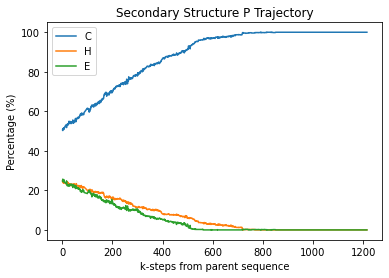

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from the text file into a Pandas DataFrame
data = pd.read_csv("results_psipred_analysis_temp/percentages_structures_P.txt", sep=" ")

# Sort the data based on the numbers behind 'A_trajectory_'
data['Number'] = data['File'].str.extract(r'P_trajectory_(\d+)\.ss2').astype(int)
data = data.sort_values(by='Number')

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(data['Number'], data['C_Percentage'], label='C')
ax.plot(data['Number'], data['H_Percentage'], label='H')
ax.plot(data['Number'], data['E_Percentage'], label='E')

# Add labels and a legend
ax.set_xlabel('k-steps from parent sequence')
ax.set_ylabel('Percentage (%)')
ax.set_title('Secondary Structure P Trajectory')
ax.legend()

plt.savefig('Secondary_Structure_P.png') 
# Show the graph
plt.show()
